In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.0.0
sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
matplotlib 3.1.3
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


## 设置GPU

In [2]:
tf.debugging.set_log_device_placement(True)   # 打印模型的GPU分布
gpus = tf.config.experimental.list_physical_devices('GPU')  # 获取所有的GPU
# GPU设置内存自增长
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print(len(gpus))
logical_gpu = tf.config.experimental.list_logical_devices('GPU')  # 获取所有的逻辑GPU
print(len(logical_gpu))

1
1


## 处理数据

### 读取数据

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)


### 生成dataset

In [5]:
def make_dataset(images, labels, epochs, batsh_size, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size).prefetch(50)   # prefetch: 从训练集中预先取出多少个数据为训练做准备，用来加速
    return dataset

epochs = 100
batch_size = 128
train_dataset = make_dataset(x_train_scaled, y_train, epochs, batch_size)

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousRandomSeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0


## 实现卷积神经网络模型

In [6]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, 
                              kernel_size=3, 
                              padding='same', 
                              activation='relu', 
                              input_shape=(28, 28, 1)))
model.add(keras.layers.Conv2D(filters=32, 
                              kernel_size=3, 
                              padding='same', 
                              activation='relu', 
                              input_shape=(28, 28, 1)))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=64,    # 在maxpooling后一般会将filters的值翻倍，以缓解maxpooling带来的参数损失 
                              kernel_size=3, 
                              padding='same', 
                              activation='relu'))
model.add(keras.layers.Conv2D(filters=64, 
                              kernel_size=3, 
                              padding='same', 
                              activation='relu', 
                              input_shape=(28, 28, 1)))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=128, 
                              kernel_size=3, 
                              padding='same', 
                              activation='relu', 
                              input_shape=(28, 28, 1)))
model.add(keras.layers.Conv2D(filters=128, 
                              kernel_size=3, 
                              padding='same', 
                              activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

In [7]:
history = model.fit(train_dataset,
                    steps_per_epoch = x_train_scaled.shape[0] // batch_size,
                    epochs=10)

Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Train for 429 steps
Epoch 1/10
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_initialize_variables_640 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_distributed_f

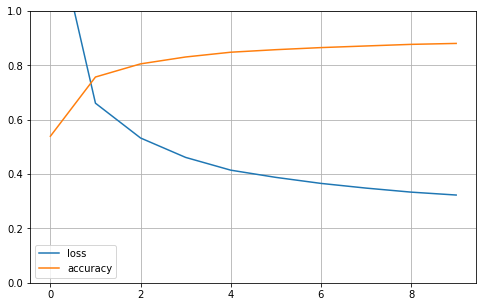

In [8]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [9]:
model.evaluate(x_test_scaled, y_test)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_13974 in device /job:localhost/replica:0/task:

[0.34327659620046613, 0.8751]